# Analysis of Reddit Comments on Climate Change
This notebook analyzes Reddit comments on climate change. Our team's goal is to analyze climate change sentiment over time through Reddit data.

SENG 550 Final Project
- Monmoy Maahdie
- Smitkumar Saraiya
- Farhan Ali
- Kai Ferrer

## 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from datetime import datetime
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list
from collections import Counter
from pyspark.sql.functions import col, length, regexp_replace, udf, split, explode
from pyspark.sql.types import DoubleType, StringType, IntegerType

from pyspark.ml.feature import Tokenizer, HashingTF, VectorAssembler, StopWordsRemover
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import from_unixtime

import tensorflow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

## 2. Create Spark Session

In [2]:
# Initialize spark session
spark = SparkSession.builder \
    .appName("Reddit Climate Change Comments") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()

24/12/19 22:58:08 WARN Utils: Your hostname, Yeontan.local resolves to a loopback address: 127.0.0.1; using 192.168.1.69 instead (on interface en0)
24/12/19 22:58:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/19 22:58:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 3. Load Data

In [ ]:
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
len(stopwords)

In [4]:
nlp.Defaults.stop_words -= {"no", "not"}

In [5]:
# Create dataframe
df = spark.read.csv("the-reddit-climate-change-dataset-comments.csv", header=True, inferSchema=True)
df = df.repartition(100)  #  increase the number of partitions for large dataset
# df.show(5, truncate=False) # checking the dataset by displaying first 5 rows
df_original = df # save original dataset

## 4. Data Cleaning

In [6]:
new_columns = [col_name.replace('.', '_') for col_name in df.columns]
df = df.toDF(*new_columns)
# df.show(5, truncate=False)

In [7]:
df_clean = df.dropna()
# df_clean.show(n=5, truncate=False)

In [8]:
df_clean = df_clean.drop("permalink")

# Separate records where sentiment and score can be cast to numbers
clean_df = df_clean.filter(
    col("sentiment").cast(DoubleType()).isNotNull() &
    col("score").cast(DoubleType()).isNotNull()
)

# Records where either sentiment or score contain non-numerical values
problematic_df = df_clean.filter(
    col("sentiment").cast(DoubleType()).isNull() |
    col("score").cast(DoubleType()).isNull()
)


## 5. Data Transformation
We start off by tokenizing the data using a spaCy model.
Then, we apply transformations to process the text.

In [9]:
clean_df_1 = clean_df.filter(col("type") == "comment") # only comments exist in here
# clean_df_1.show(n=10, truncate=False)

In [10]:
# Load spacy model
nlp = spacy.load('en_core_web_sm')

# Define the preprocessing function
def preprocess(comment):
    doc = nlp(comment)
    processed_words_list = []
    for token in doc:
        if not token.is_punct and not token.like_url and not token.is_stop:
            processed_words_list.append(token.lemma_.strip().lower())
    return ' '.join(processed_words_list)

    
# Create a UDF from the function
preprocess_udf = udf(preprocess, StringType())


In [11]:
# Apply the UDF to create a new column
clean_df_2 = clean_df_1.withColumn('processed_body', preprocess_udf(col('body')))
clean_df_2.show(n=5, truncate=False)

24/12/19 20:23:07 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------+-------+------------+--------------+--------------+-----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Now, we are categorizing sentiments across 3 classes: negative, neutral, and positive sentiments. This is a necessary step as part of data transformation.

In [12]:
def create_label(sentiment):
    if float(sentiment) < -0.05:
        return -1
    elif float(sentiment) >= -0.05 and float(sentiment) <= 0.05:
        return 0
    else:
        return 1

create_label_udf = udf(create_label, IntegerType())


In [13]:
clean_df_3 = clean_df_2.withColumn('label', create_label_udf(col('sentiment')))
# Count occurrences of each subreddit_name and order by count in descending order
subreddit_counts = clean_df_3.groupBy('subreddit_name') \
    .count() \
    .orderBy('count', ascending=False)

# Show the results


In [14]:
# subreddit_counts.filter(subreddit_counts['subreddit_name'] == 'climate').show()
clean_df_3 = clean_df_3.withColumn("sentiment", col("sentiment").cast(DoubleType()))


## 6. Data Analysis & Visualization

In [15]:
clean_df_3.show(5, truncate=False)

+-------+-------+------------+--------------+--------------+-----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+-----+------+
|label| count|
+-----+------+
|   -1|221710|
|    1|196212|
|    0| 73533|
+-----+------+



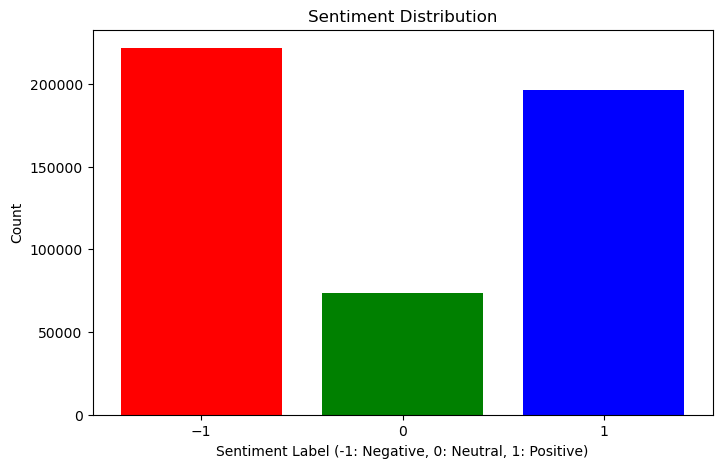

In [16]:
# Distribution of sentiment
sentiment_distribution = clean_df_3.groupBy('label').count() # Aggregation
sentiment_distribution.show()

sentiment_pd = sentiment_distribution.toPandas() #convert to pandas

# Graph
plt.figure(figsize=(8, 5))
plt.bar(sentiment_pd['label'], sentiment_pd['count'], color=['red', 'blue', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Label (-1: Negative, 0: Neutral, 1: Positive)')
plt.ylabel('Count')
plt.xticks(sentiment_pd['label'])
plt.show()

+--------------+-----+
|subreddit_name|count|
+--------------+-----+
|     askreddit|28643|
|     worldnews|24793|
|      politics|15214|
|      collapse|13628|
|    conspiracy| 9308|
|   environment| 8839|
|          news| 8292|
|        canada| 7355|
|    futurology| 6295|
|    neoliberal| 5953|
+--------------+-----+
only showing top 10 rows



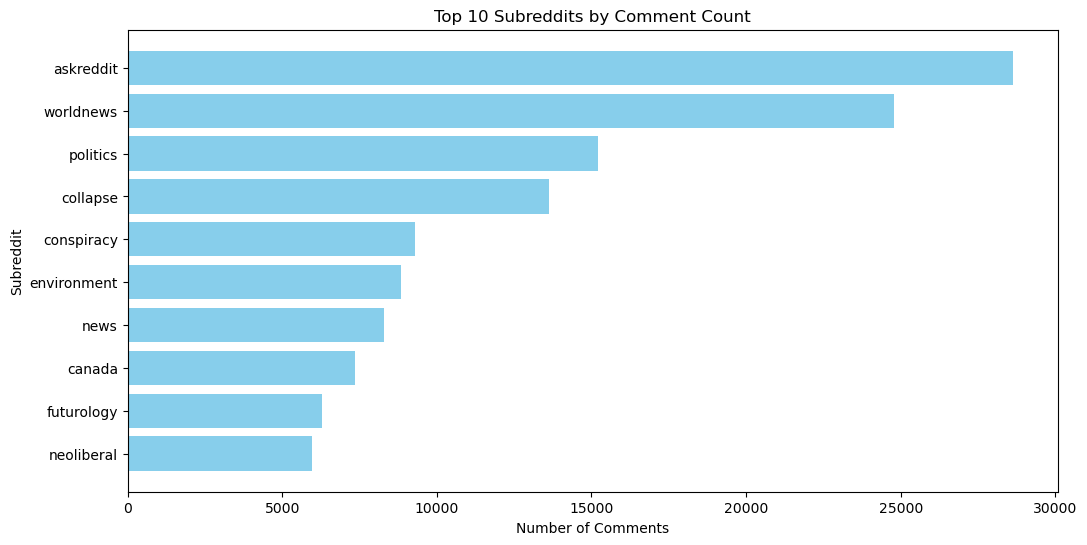

In [17]:
# Top Subreddits by Comments
# Group by subreddit_name and count occurrences
subreddit_counts = clean_df_3.groupBy('subreddit_name').count().orderBy('count', ascending=False)
subreddit_counts.show(10)
subreddit_pd = subreddit_counts.limit(10).toPandas()

# Graph
plt.figure(figsize=(12, 6))
plt.barh(subreddit_pd['subreddit_name'], subreddit_pd['count'], color='skyblue')
plt.title('Top 10 Subreddits by Comment Count')
plt.xlabel('Number of Comments')
plt.ylabel('Subreddit')
plt.gca().invert_yaxis()
plt.show()

+----------+--------------------+
|      date|   average_sentiment|
+----------+--------------------+
|2021-05-02|-0.03580107197549...|
|2021-05-03|-0.00929129172714...|
|2021-05-04| -0.0353506129597198|
|2021-05-05|-0.00237381703470...|
|2021-05-06|-0.03327734265734265|
|2021-05-07|-0.05340483005366728|
|2021-05-08|0.022720526315789476|
|2021-05-09|-0.01173386524822...|
|2021-05-10|-0.03480850393700...|
|2021-05-11|-0.04821552346570396|
|2021-05-12|-0.06504837133550488|
|2021-05-13|-0.01709604130808...|
|2021-05-14|0.003049840255591058|
|2021-05-15|-0.08891040650406504|
|2021-05-16|-0.02311151385927...|
|2021-05-17|-0.05726053240740742|
|2021-05-18|-0.03515240384615385|
|2021-05-19|-0.04121307189542483|
|2021-05-20|-0.02818316430020...|
|2021-05-21|0.004087321428571427|
+----------+--------------------+
only showing top 20 rows



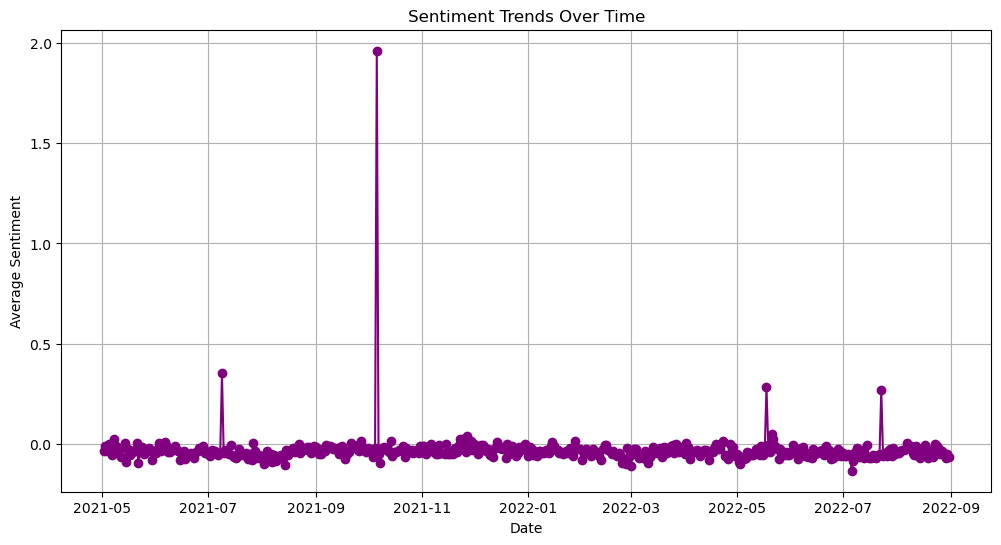

In [18]:
# Sentiment over time
# Ensure created_utc is cast to long
clean_df_3 = clean_df_3.withColumn("created_utc", col("created_utc").cast("long"))

# Convert created_utc to a date column
def convert_to_date(timestamp):
    return pd.to_datetime(timestamp, unit='s').strftime('%Y-%m-%d')

convert_to_date_udf = udf(convert_to_date, StringType())
clean_df_3 = clean_df_3.withColumn('date', convert_to_date_udf(col('created_utc')))

# Group by date and calculate average sentiment
sentiment_trends = clean_df_3.groupBy('date').agg({'sentiment': 'mean'}).orderBy('date')
sentiment_trends = sentiment_trends.withColumnRenamed('avg(sentiment)', 'average_sentiment')
sentiment_trends.show()

# Convert to Pandas for visualization
trends_pd = sentiment_trends.toPandas()
trends_pd['date'] = pd.to_datetime(trends_pd['date'])

# Plot sentiment trends over time
plt.figure(figsize=(12, 6))
plt.plot(trends_pd['date'], trends_pd['average_sentiment'], color='purple', marker='o')
plt.title('Sentiment Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.show()


In [19]:
# First, let's create a DataFrame from the cleaned data
df_time = clean_df_3.toPandas()

# Convert timestamp to datetime
df_time['created_utc'] = pd.to_datetime(df_time['created_utc'], unit='s')

# Extract year
df_time['year'] = df_time['created_utc'].dt.year

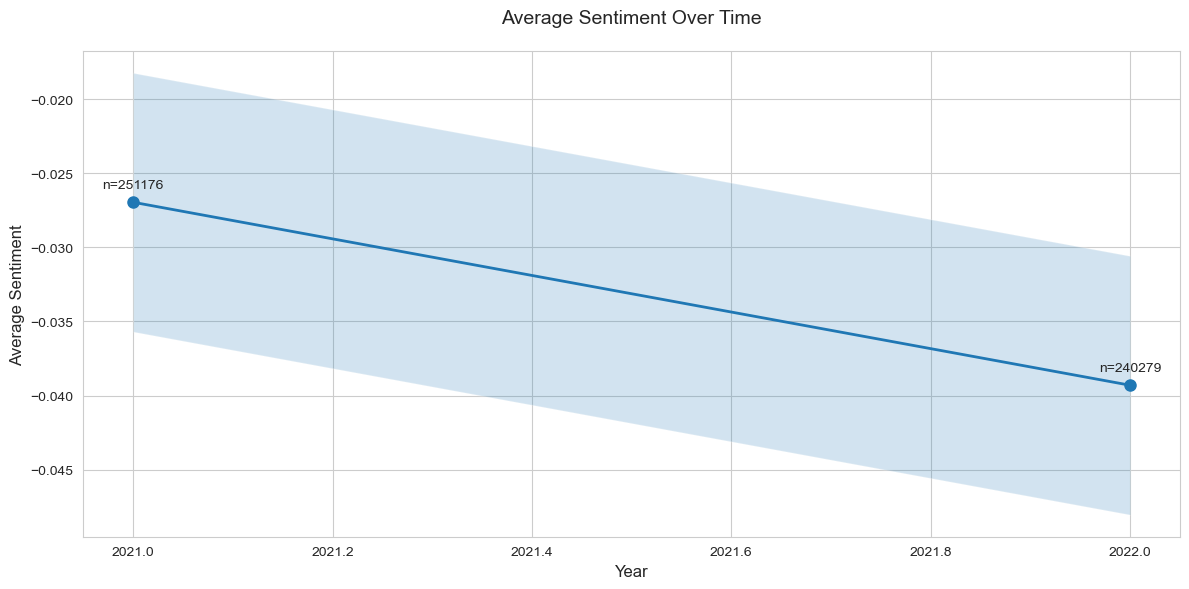


Yearly Statistics:
   year   mean   count
0  2021 -0.027  251176
1  2022 -0.039  240279


In [23]:
# Calculate average sentiment per year
yearly_sentiment = df_time.groupby('year')['sentiment'].agg(['mean', 'count']).reset_index()

# Create the visualization
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create the line plot
plt.plot(yearly_sentiment['year'], yearly_sentiment['mean'], marker='o', linewidth=2, markersize=8)

# Add error bars (optional)
plt.fill_between(yearly_sentiment['year'], 
                 yearly_sentiment['mean'] - yearly_sentiment['mean'].std(),
                 yearly_sentiment['mean'] + yearly_sentiment['mean'].std(),
                 alpha=0.2)

# Customize the plot
plt.title('Average Sentiment Over Time', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)

# Add number of comments per year as annotations
for i, row in yearly_sentiment.iterrows():
    plt.annotate(f'n={int(row["count"])}', 
                (row['year'], row['mean']),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

plt.tight_layout()
plt.show()

# Print the yearly statistics
print("\nYearly Statistics:")
print(yearly_sentiment.round(3))

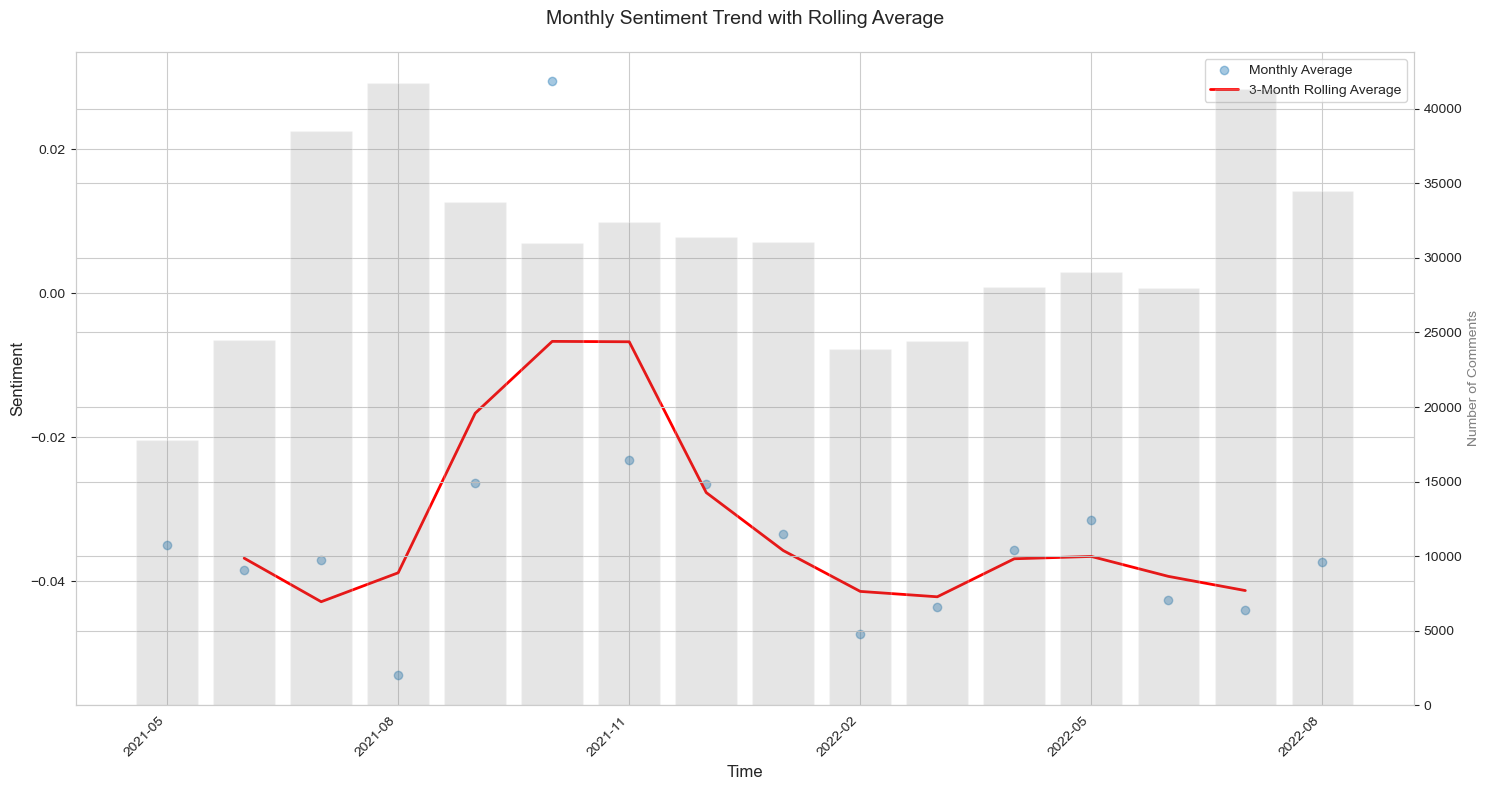

In [24]:
# Convert to monthly data with rolling average
df_time['yearmonth'] = df_time['created_utc'].dt.to_period('M')
monthly_sentiment = df_time.groupby('yearmonth')['sentiment'].agg(['mean', 'count']).reset_index()
monthly_sentiment['yearmonth'] = monthly_sentiment['yearmonth'].astype(str)

# Calculate 3-month rolling average
monthly_sentiment['rolling_mean'] = monthly_sentiment['mean'].rolling(window=3, center=True).mean()

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# Plot actual monthly values as light scatter points
plt.scatter(range(len(monthly_sentiment)), monthly_sentiment['mean'], 
           alpha=0.4, label='Monthly Average')

# Plot rolling average as a solid line
plt.plot(range(len(monthly_sentiment)), monthly_sentiment['rolling_mean'], 
         linewidth=2, color='red', label='3-Month Rolling Average')

# Customize the plot
plt.title('Monthly Sentiment Trend with Rolling Average', fontsize=14, pad=20)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sentiment', fontsize=12)

# Set x-axis ticks to show every nth month
n = 3  # adjust this value to show more or fewer x-axis labels
plt.xticks(range(0, len(monthly_sentiment), n), 
           monthly_sentiment['yearmonth'][::n], 
           rotation=45, ha='right')

# Add legend
plt.legend()

# Add volume indication
ax2 = plt.twinx()
ax2.bar(range(len(monthly_sentiment)), monthly_sentiment['count'], 
        alpha=0.2, color='gray', label='Number of Comments')
ax2.set_ylabel('Number of Comments', color='gray')

plt.tight_layout()
plt.show()

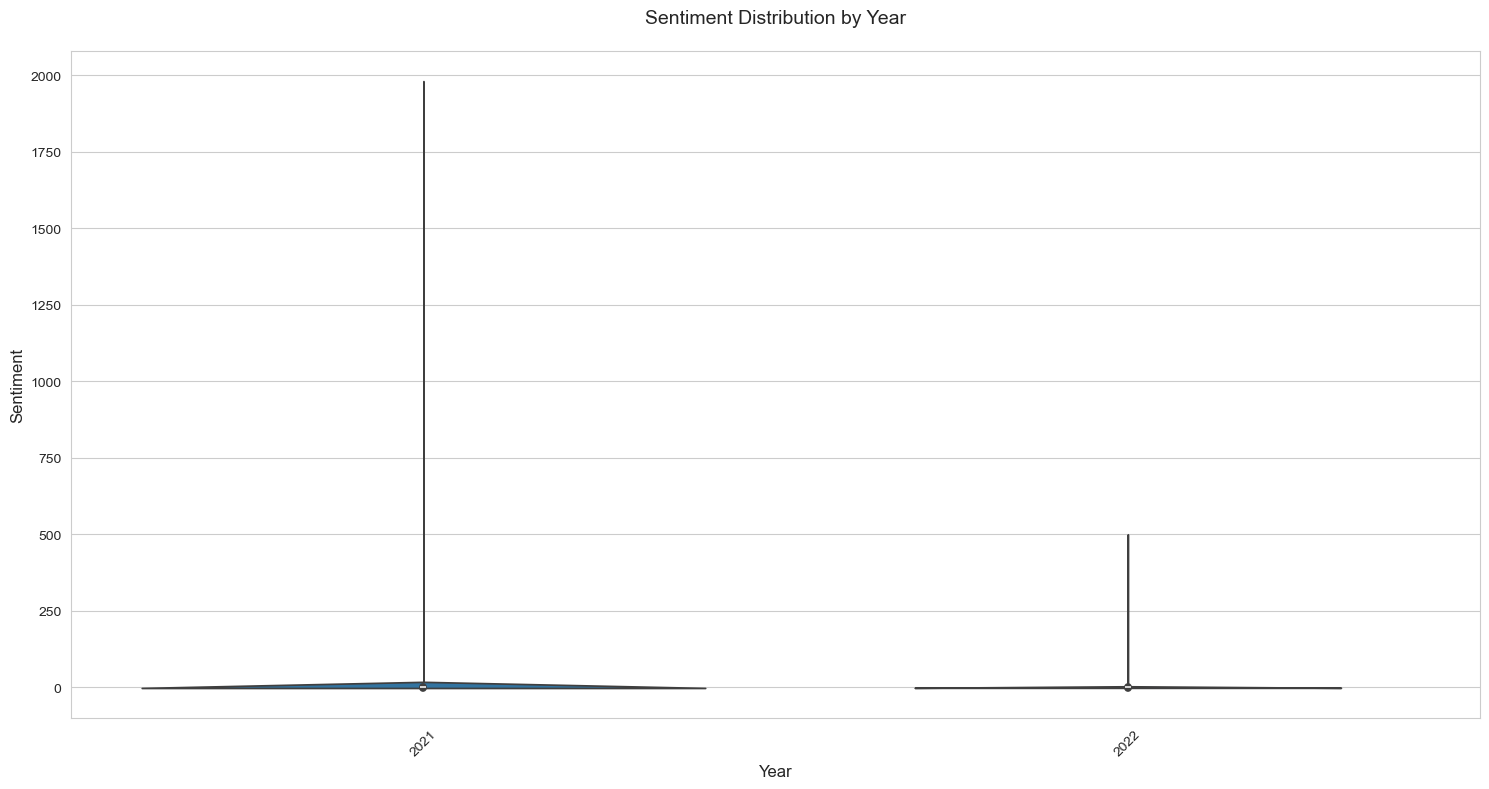

In [25]:
# Create a more detailed visualization showing sentiment distribution
plt.figure(figsize=(15, 8))

# Create violin plot
sns.violinplot(data=df_time, x=df_time['created_utc'].dt.year, y='sentiment')

plt.title('Sentiment Distribution by Year', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sentiment', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [30]:
# First, calculate the quarterly statistics
df_time = clean_df_3.toPandas()
df_time['created_utc'] = pd.to_datetime(df_time['created_utc'], unit='s')

# Extract year and quarter
df_time['year'] = df_time['created_utc'].dt.year
df_time['quarter'] = df_time['created_utc'].dt.to_period('Q')

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


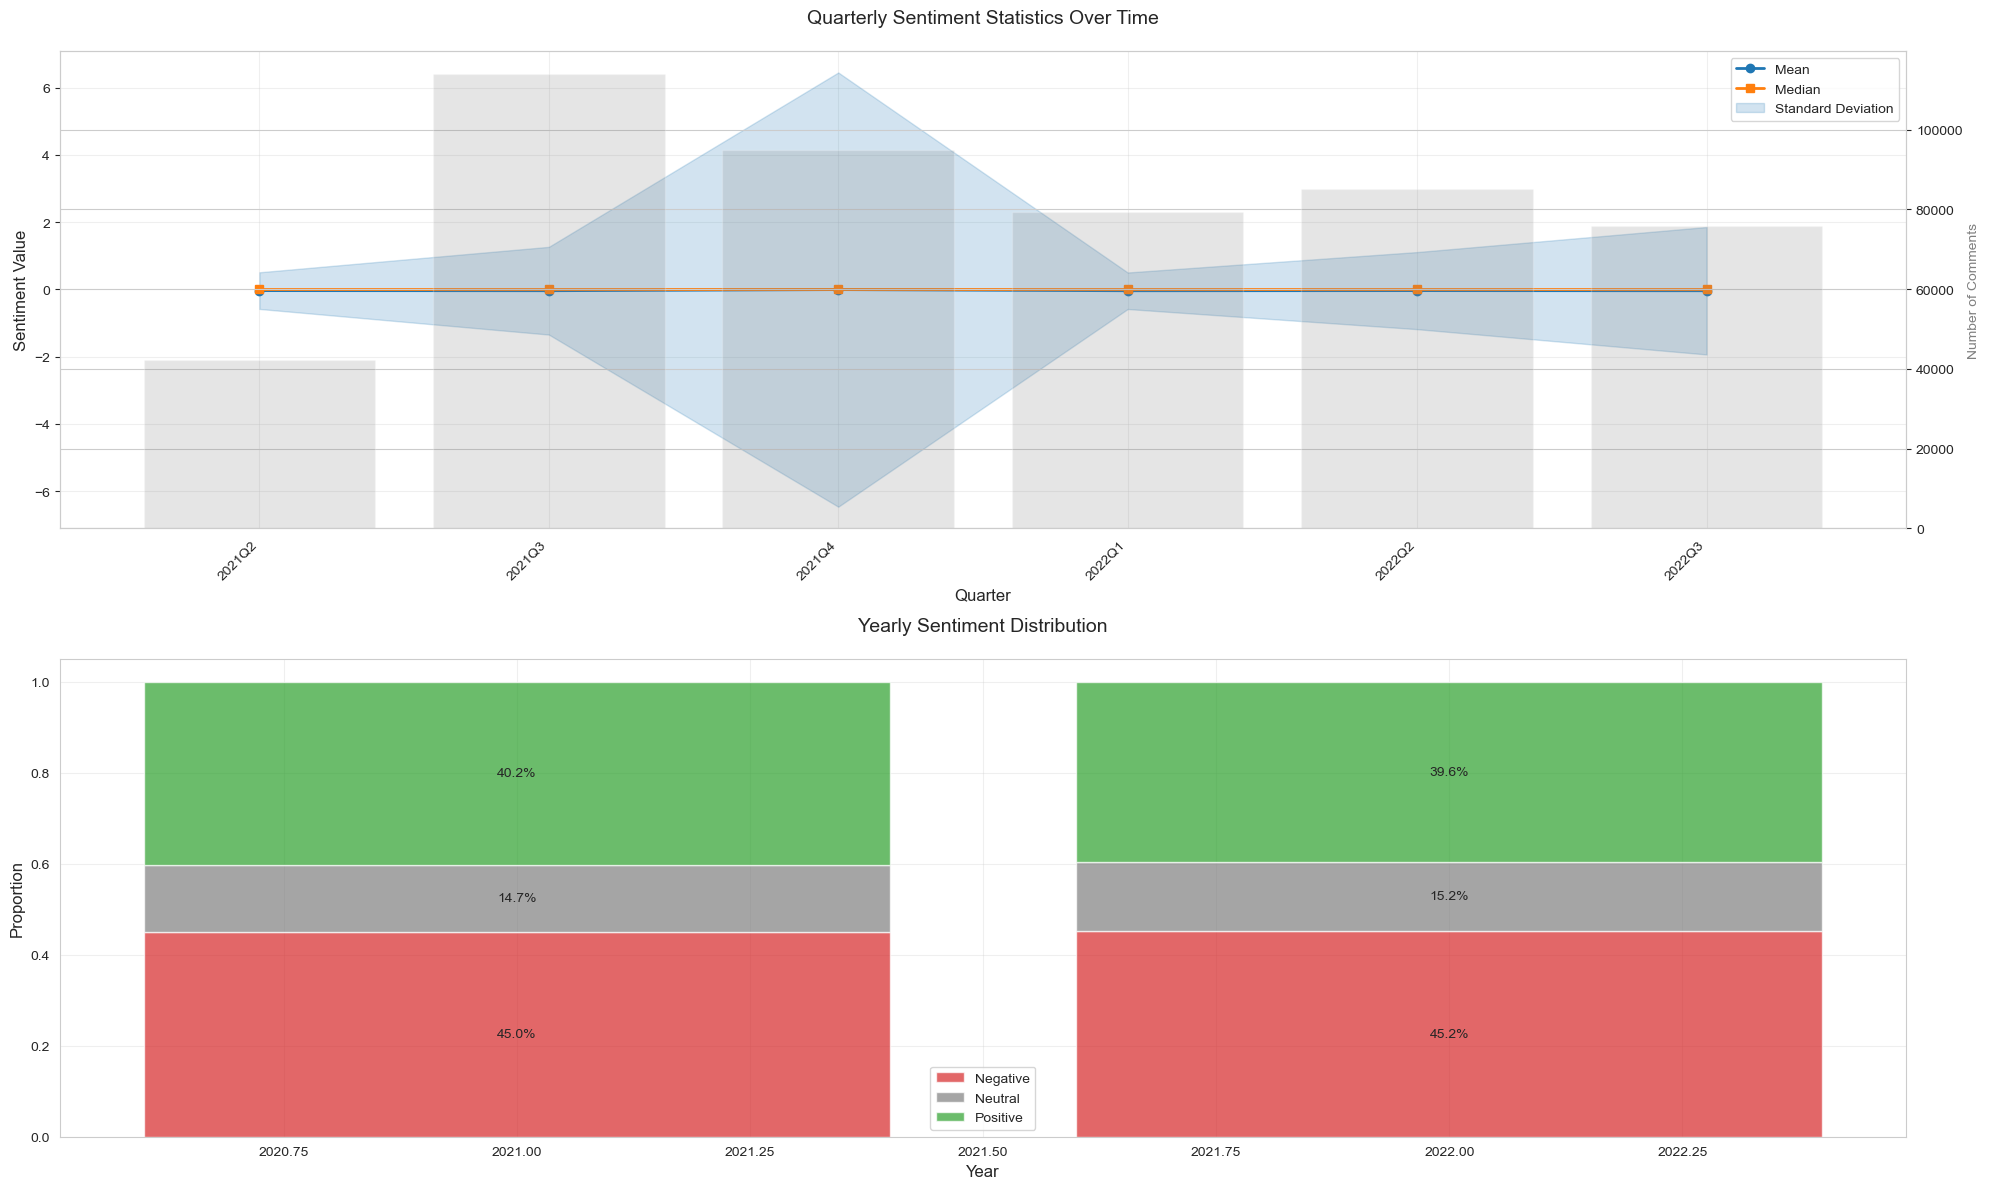


Quarterly Statistics:
        sentiment                                      
            count   mean    std median    min       max
quarter                                                
2021Q2      42323 -0.037  0.545    0.0 -0.999     0.997
2021Q3     114040 -0.040  1.304    0.0 -0.999   400.000
2021Q4      94813 -0.007  6.455    0.0 -0.999  1980.000
2022Q1      79368 -0.041  0.543    0.0 -0.999     0.998
2022Q2      85102 -0.037  1.146    0.0 -0.998   294.000
2022Q3      75809 -0.041  1.894    0.0 -0.999   500.000

Yearly Sentiment Distribution:
   year  Negative   Neutral  Positive
0  2022  0.452183  0.151961  0.395856
1  2021  0.450123  0.147387  0.402491


In [32]:
# Calculate quarterly statistics
quarterly_stats = df_time.groupby('quarter').agg({
    'sentiment': ['count', 'mean', 'std', 'median', 'min', 'max']
}).round(3)

# Calculate sentiment distribution with different method
yearly_sentiments = []
for year in df_time['year'].unique():
    year_data = df_time[df_time['year'] == year]
    negative = (year_data['sentiment'] < -0.05).mean()
    neutral = ((year_data['sentiment'] >= -0.05) & (year_data['sentiment'] <= 0.05)).mean()
    positive = (year_data['sentiment'] > 0.05).mean()
    yearly_sentiments.append({
        'year': year,
        'Negative': negative,
        'Neutral': neutral,
        'Positive': positive
    })
sentiment_distribution_plot = pd.DataFrame(yearly_sentiments)

# Now create the visualization
fig = plt.figure(figsize=(20, 12))

# 1. Quarterly Statistics Plot
ax1 = plt.subplot(2, 1, 1)

# Reset the index and convert quarter to string for plotting
quarterly_stats_plot = quarterly_stats.reset_index()
quarterly_stats_plot['quarter'] = quarterly_stats_plot['quarter'].astype(str)

# Plot different statistics
plt.plot(quarterly_stats_plot['quarter'], quarterly_stats_plot['sentiment']['mean'], 
         label='Mean', marker='o', linewidth=2, color='#1f77b4')
plt.plot(quarterly_stats_plot['quarter'], quarterly_stats_plot['sentiment']['median'], 
         label='Median', marker='s', linewidth=2, color='#ff7f0e')

# Add standard deviation band
plt.fill_between(quarterly_stats_plot['quarter'],
                 quarterly_stats_plot['sentiment']['mean'] - quarterly_stats_plot['sentiment']['std'],
                 quarterly_stats_plot['sentiment']['mean'] + quarterly_stats_plot['sentiment']['std'],
                 alpha=0.2, label='Standard Deviation', color='#1f77b4')

plt.title('Quarterly Sentiment Statistics Over Time', fontsize=14, pad=20)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Sentiment Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# Add comment count as bar plot on secondary axis
ax2 = ax1.twinx()
ax2.bar(range(len(quarterly_stats_plot)), quarterly_stats_plot['sentiment']['count'], 
        alpha=0.2, color='gray', label='Number of Comments')
ax2.set_ylabel('Number of Comments', color='gray')

# 2. Yearly Sentiment Distribution Plot
plt.subplot(2, 1, 2)

years = sentiment_distribution_plot['year']

# Create stacked bar plot
plt.bar(years, sentiment_distribution_plot['Negative'], label='Negative', color='#d62728', alpha=0.7)
plt.bar(years, sentiment_distribution_plot['Neutral'], 
        bottom=sentiment_distribution_plot['Negative'], 
        label='Neutral', color='#7f7f7f', alpha=0.7)
plt.bar(years, sentiment_distribution_plot['Positive'], 
        bottom=sentiment_distribution_plot['Negative'] + sentiment_distribution_plot['Neutral'],
        label='Positive', color='#2ca02c', alpha=0.7)

plt.title('Yearly Sentiment Distribution', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Add percentage labels on the bars
for i in range(len(years)):
    # Calculate positions for text
    neg_pos = sentiment_distribution_plot['Negative'].iloc[i] / 2
    neu_pos = sentiment_distribution_plot['Negative'].iloc[i] + sentiment_distribution_plot['Neutral'].iloc[i] / 2
    pos_pos = (sentiment_distribution_plot['Negative'].iloc[i] + 
               sentiment_distribution_plot['Neutral'].iloc[i] + 
               sentiment_distribution_plot['Positive'].iloc[i] / 2)
    
    # Add text labels (showing percentages)
    plt.text(years.iloc[i], neg_pos, f"{sentiment_distribution_plot['Negative'].iloc[i]:.1%}", 
             ha='center', va='center')
    plt.text(years.iloc[i], neu_pos, f"{sentiment_distribution_plot['Neutral'].iloc[i]:.1%}", 
             ha='center', va='center')
    plt.text(years.iloc[i], pos_pos, f"{sentiment_distribution_plot['Positive'].iloc[i]:.1%}", 
             ha='center', va='center')

plt.tight_layout()
plt.show()

# Print the statistics
print("\nQuarterly Statistics:")
print(quarterly_stats)
print("\nYearly Sentiment Distribution:")
print(sentiment_distribution_plot)

## 7. Sentiment Prediction Model

In [34]:
df_ml = clean_df_3.toPandas()


texts = df_ml['processed_body'].values
labels = df_ml['label'].values


In [35]:
# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [36]:
# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length)

In [37]:
# Convert labels to categorical
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [38]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, 
    encoded_labels, 
    test_size=0.2, 
    random_state=42
)


In [39]:
# Build the model
model = Sequential([
    Embedding(10000, 32, input_length=max_length),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])


/home/csusers/smitkumar.saraiya/.local/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-12-19 21:08:31.162195: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [40]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [41]:
# Train the model with early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/10
9830/9830 ━━━━━━━━━━━━━━━━━━━━ 230s 23ms/step - accuracy: 0.7760 - loss: 0.5555 - val_accuracy: 0.8590 - val_loss: 0.4019
Epoch 2/10
9830/9830 ━━━━━━━━━━━━━━━━━━━━ 225s 23ms/step - accuracy: 0.8682 - loss: 0.3821 - val_accuracy: 0.8632 - val_loss: 0.3913
Epoch 3/10
9830/9830 ━━━━━━━━━━━━━━━━━━━━ 225s 23ms/step - accuracy: 0.8752 - loss: 0.3603 - val_accuracy: 0.8646 - val_loss: 0.3897
Epoch 4/10
9830/9830 ━━━━━━━━━━━━━━━━━━━━ 221s 23ms/step - accuracy: 0.8824 - loss: 0.3398 - val_accuracy: 0.8629 - val_loss: 0.3949
Epoch 5/10
9830/9830 ━━━━━━━━━━━━━━━━━━━━ 222s 23ms/step - accuracy: 0.8910 - loss: 0.3168 - val_accuracy: 0.8596 - val_loss: 0.4090
Epoch 6/10
9830/9830 ━━━━━━━━━━━━━━━━━━━━ 222s 23ms/step - accuracy: 0.8970 - loss: 0.2981 - val_accuracy: 0.8573 - val_loss: 0.4245


In [42]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy*100:.2f}")

# Function to predict sentiment for new text
def predict_sentiment(text):
    # Preprocess the text similarly to training data
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_length)
    prediction = model.predict(padded)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_class[0]

3072/3072 ━━━━━━━━━━━━━━━━━━━━ 50s 16ms/step - accuracy: 0.8662 - loss: 0.3844
Test accuracy: 86.46


In [43]:
#Save some example predictions
example_texts = [
    "climate change is a serious threat to our planet",
    "we need to take action on environmental issues",
    "this climate change discussion is pointless"
]

print("\nExample predictions:")
for text in example_texts:
    sentiment = predict_sentiment(text)
    print(f"Text: {text}")
    print(f"Predicted sentiment: {sentiment}\n")




Example predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Text: climate change is a serious threat to our planet
Predicted sentiment: -1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Text: we need to take action on environmental issues
Predicted sentiment: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Text: this climate change discussion is pointless
Predicted sentiment: 0



Performance metrics of the model

3072/3072 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step

Detailed Metrics:

Recall Scores:
Negative: 0.9079
Neutral: 0.7720
Positive: 0.8503
Macro Average: 0.8434
Weighted Average: 0.8646

F1 Scores:
Negative: 0.8781
Neutral: 0.8279
Positive: 0.8616
Macro Average: 0.8559
Weighted Average: 0.8640


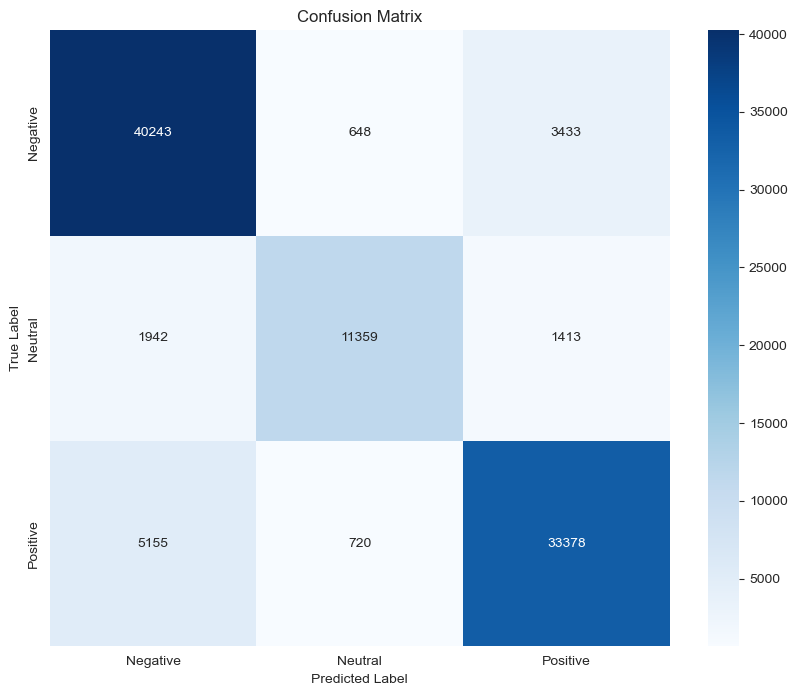

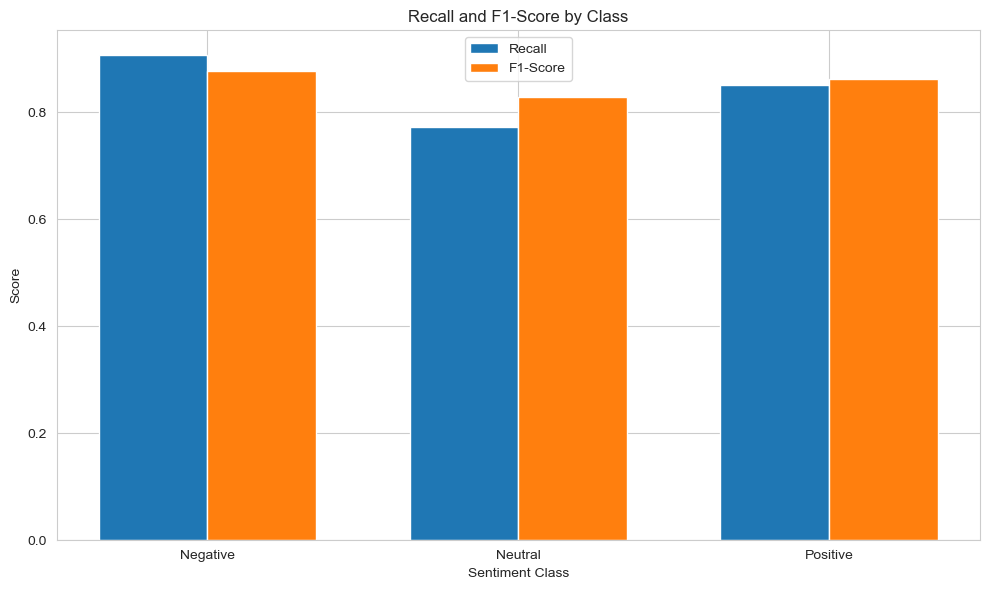

In [50]:
# Get model predictions on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

recall_per_class = recall_score(y_test, y_pred, average=None)
f1_per_class = f1_score(y_test, y_pred, average=None)

# Calculate macro and weighted averages
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

# Print detailed metrics
print("\nDetailed Metrics:")
print("\nRecall Scores:")
for i, score in enumerate(['Negative', 'Neutral', 'Positive']):
    print(f"{score}: {recall_per_class[i]:.4f}")
print(f"Macro Average: {recall_macro:.4f}")
print(f"Weighted Average: {recall_weighted:.4f}")

print("\nF1 Scores:")
for i, score in enumerate(['Negative', 'Neutral', 'Positive']):
    print(f"{score}: {f1_per_class[i]:.4f}")
print(f"Macro Average: {f1_macro:.4f}")
print(f"Weighted Average: {f1_weighted:.4f}")
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate and plot per-class metrics
metrics_df = pd.DataFrame({
    'Class': ['Negative', 'Neutral', 'Positive'],
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
})

plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(metrics_df['Class']))

plt.bar(x - bar_width/2, metrics_df['Recall'], bar_width, label='Recall')
plt.bar(x + bar_width/2, metrics_df['F1-Score'], bar_width, label='F1-Score')

plt.xlabel('Sentiment Class')
plt.ylabel('Score')
plt.title('Recall and F1-Score by Class')
plt.xticks(x, metrics_df['Class'])
plt.legend()
plt.tight_layout()
plt.show()

# Function to print metrics for a single prediction
def predict_with_metrics(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_length)
    prediction_probs = model.predict(padded)
    predicted_class = np.argmax(prediction_probs)
    confidence = prediction_probs[0][predicted_class]
    
    class_names = ['Negative', 'Neutral', 'Positive']
    predicted_sentiment = class_names[predicted_class]
    
    print(f"\nText: {text}")
    print(f"Predicted Sentiment: {predicted_sentiment}")
    print(f"Confidence: {confidence:.2%}")
    print("\nProbabilities for each class:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {prediction_probs[0][i]:.2%}")
    
    return predicted_sentiment, confidence


In [ ]:
# Calculate metrics
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

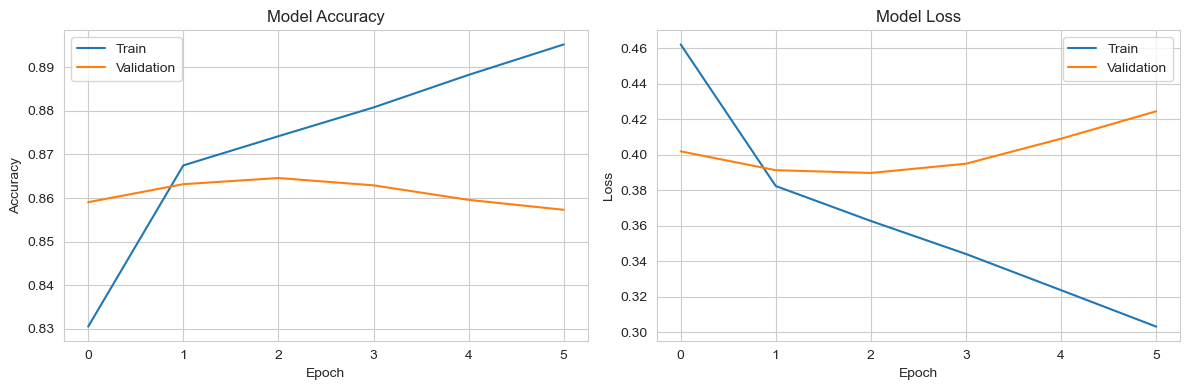

In [44]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [45]:
# Interactive prediction
while True:
    try:
        x = int(input("\nEnter a number between 0 and 491454 inclusive (or -1 to exit): "))
        if x == -1:
            break
        if 0 <= x <= 491454:
            sentiment = predict_sentiment(texts[x])
            print(f"\nText: {texts[x]}")
            print(f"Predicted sentiment: {sentiment}")
            # Also print the actual sentiment for comparison
            print(f"Actual sentiment: {labels[x]}")
        else:
            print("Number out of range. Please enter a valid number.")
    except ValueError:
        print("Please enter a valid integer.")
    except IndexError:
        print("Index out of range. Please enter a valid number.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Text: serve irritate pro climate change federal minister advance saskatchewan interest hmm
Predicted sentiment: -1
Actual sentiment: -1


## 8. End

In [46]:
spark.stop()